In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
!pip install sklearn-ts==0.0.4

# Load data

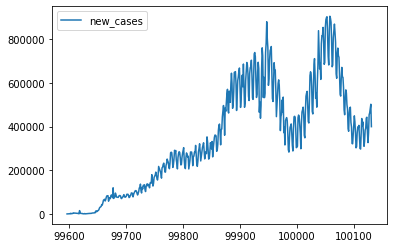

In [23]:
covid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")
#covid.head(2)

target = 'new_cases'
h = 14

dataset = covid[(covid['location']=='World')].copy()[[target, 'date']]
dataset[[target]].plot()

In [24]:
# prepare features
features = ['year', 'month', f'{h}_lag', f'{h}_lag_rolling', 'dayofweek', 'intercept', 'trend', 'log']
categorical_features = ['year', 'month', 'dayofweek']
numerical_features = [f'{h}_lag', f'{h}_lag_rolling', 'intercept', 'trend', 'log']

dataset['date'] = pd.to_datetime(dataset['date'])
dataset.index = dataset['date']
dataset['month'] = dataset['date'].dt.month
dataset['year'] = dataset['date'].dt.year
dataset['dayofweek'] = dataset['date'].dt.dayofweek
dataset[f'{h}_lag'] = dataset[target].shift(h)
dataset[f'rolling_{target}'] = dataset[target].rolling(window=h).mean()
dataset[f'{h}_lag_rolling'] = dataset[f'rolling_{target}'].shift(h)
dataset['intercept'] = 1
dataset['trend'] = range(dataset.shape[0])
dataset['log'] = dataset['trend'].apply(lambda x: math.log(x+1))
dataset = dataset[['date', target] + numerical_features +categorical_features]
dataset = dataset.dropna()

In [25]:
dataset[features + [target]].tail()

,year,month,14_lag,14_lag_rolling,dayofweek,intercept,trend,log,new_cases
date,,,,,,,,,
2021-07-06,2021,7,372137.0,368521.500000,1,1,531,6.276643,453745.0
2021-07-07,2021,7,437255.0,369790.285714,2,1,532,6.278521,463849.0
2021-07-08,2021,7,403842.0,366528.571429,3,1,533,6.280396,481535.0
2021-07-09,2021,7,421740.0,366563.357143,4,1,534,6.282267,502675.0
2021-07-10,2021,7,362819.0,365914.500000,5,1,535,6.284134,399937.0


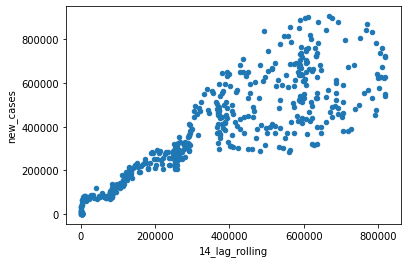

In [26]:
ax = dataset[[f'{h}_lag_rolling', 'new_cases']].plot.scatter(x=f'{h}_lag_rolling', y='new_cases')
fig = ax.get_figure()
fig.savefig('scatter.png')

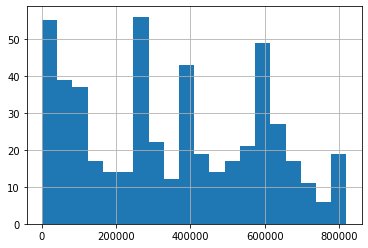

In [27]:
ax = dataset[f'{h}_lag_rolling'].hist(bins=20)
fig = ax.get_figure()
fig.savefig('hist.png')

# Splitting data

In [28]:
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html?highlight=timeseriessplit#sklearn.model_selection.TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

In [29]:
tss = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tss.split(dataset):
  print(dataset.iloc[train_index].index, dataset.iloc[test_index].index)

DatetimeIndex(['2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
               '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25',
               '2020-02-26', '2020-02-27',
               ...
               '2020-07-28', '2020-07-29', '2020-07-30', '2020-07-31',
               '2020-08-01', '2020-08-02', '2020-08-03', '2020-08-04',
               '2020-08-05', '2020-08-06'],
              dtype='datetime64[ns]', name='date', length=171, freq=None) DatetimeIndex(['2020-08-07', '2020-08-08', '2020-08-09', '2020-08-10',
               '2020-08-11', '2020-08-12', '2020-08-13', '2020-08-14',
               '2020-08-15', '2020-08-16',
               ...
               '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
               '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20',
               '2021-01-21', '2021-01-22'],
              dtype='datetime64[ns]', name='date', length=169, freq=None)
DatetimeIndex(['2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
 

In [30]:
from sklearn_ts.splitter import custom_split
from sklearn_ts.validator import check_model

In [31]:
custom_split(dataset, h=h, n_splits=2, gap=h)[1]

[(DatetimeIndex(['2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
                 '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25',
                 '2020-02-26', '2020-02-27',
                 ...
                 '2021-06-17', '2021-06-18', '2021-06-19', '2021-06-20',
                 '2021-06-21', '2021-06-22', '2021-06-23', '2021-06-24',
                 '2021-06-25', '2021-06-26'],
                dtype='datetime64[ns]', name='date', length=495, freq=None),
  DatetimeIndex(['2021-06-27', '2021-06-28', '2021-06-29', '2021-06-30',
                 '2021-07-01', '2021-07-02', '2021-07-03', '2021-07-04',
                 '2021-07-05', '2021-07-06', '2021-07-07', '2021-07-08',
                 '2021-07-09', '2021-07-10'],
                dtype='datetime64[ns]', name='date', freq=None)),
 (DatetimeIndex(['2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
                 '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25',
                 '2020-02-26', '2020-02-27

#Linear Regression

In [48]:
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
from sklearn.linear_model import LinearRegression

Grid search
Fitting to train
Plot


{'regressor__fit_intercept': False}

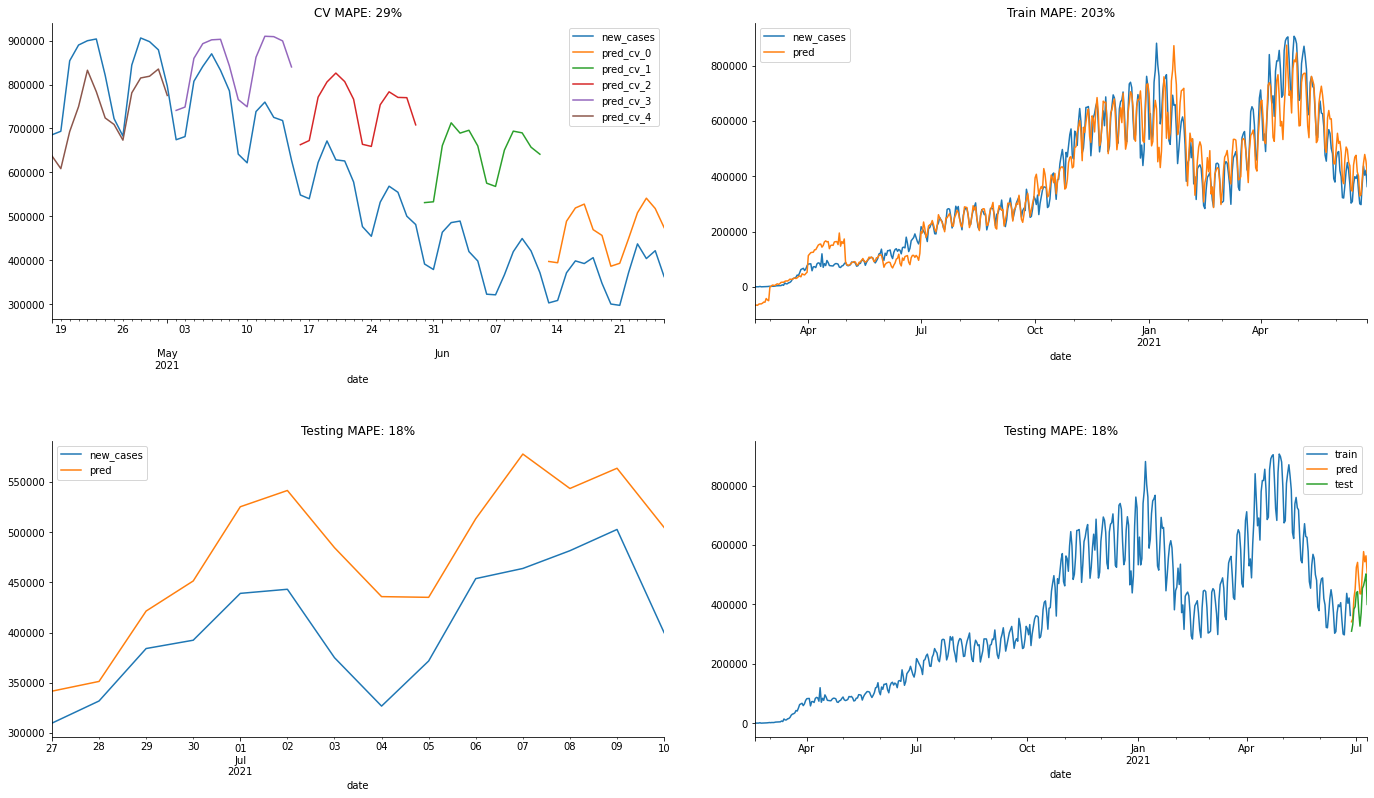

In [66]:
lr_params = {'fit_intercept': [False]}
lr = LinearRegression()

results = check_model(lr, lr_params, dataset, features=features, categorical_features=categorical_features)
results['best_params']

# Support Vector Regression

In [50]:
from sklearn.svm import SVR

Grid search
Fitting to train
Plot


{'regressor__C': 100000, 'regressor__kernel': 'rbf'}

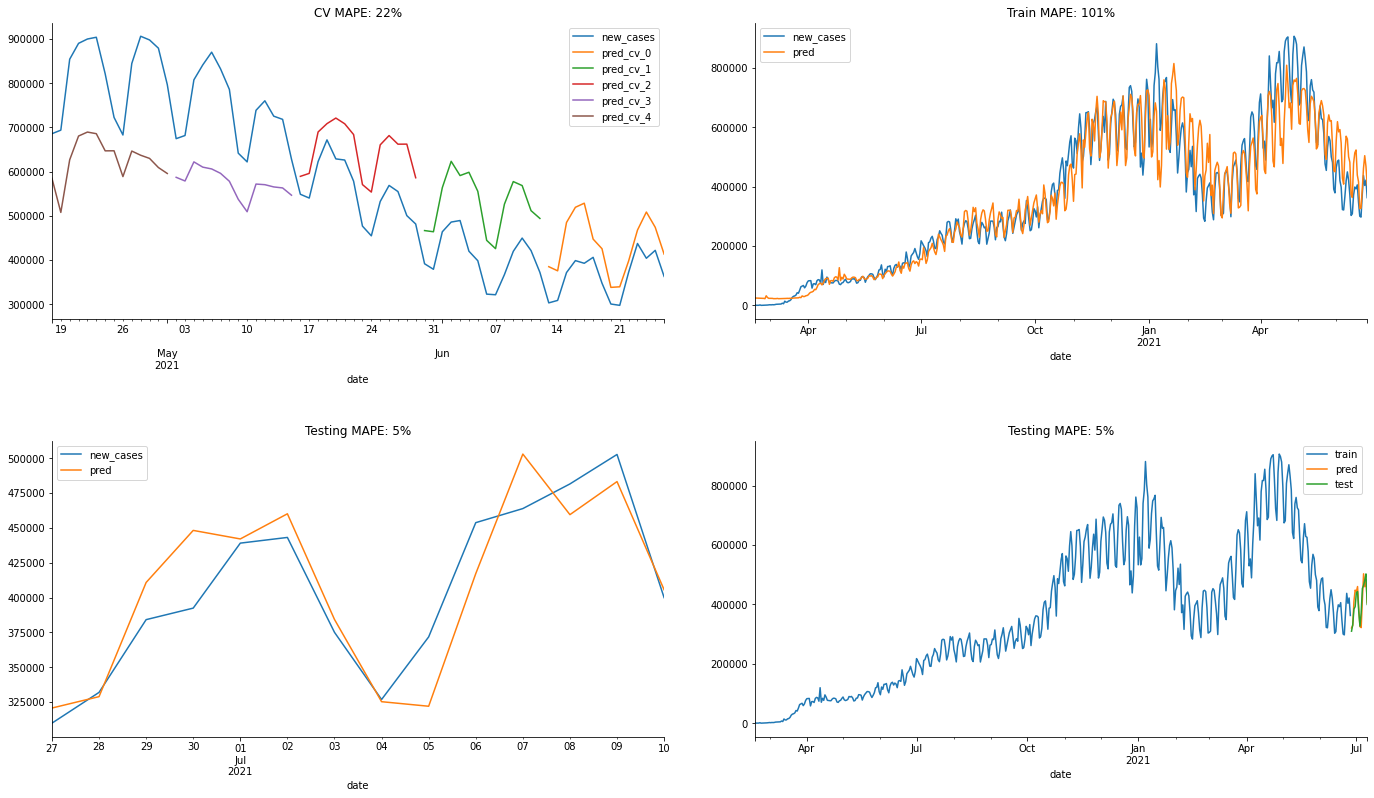

In [67]:
svr_params = {'C': [50000, 100000], 'kernel': ['rbf']}
svr = SVR()

results = check_model(svr, svr_params, dataset, features=features, categorical_features=categorical_features)
results['best_params']

# Trees

## Regression Trees

In [52]:
#https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
from sklearn.tree import DecisionTreeRegressor

Grid search
Fitting to train
Plot


{'regressor__criterion': 'mae',
 'regressor__max_depth': 15,
 'regressor__min_samples_leaf': 1,
 'regressor__min_samples_split': 2}

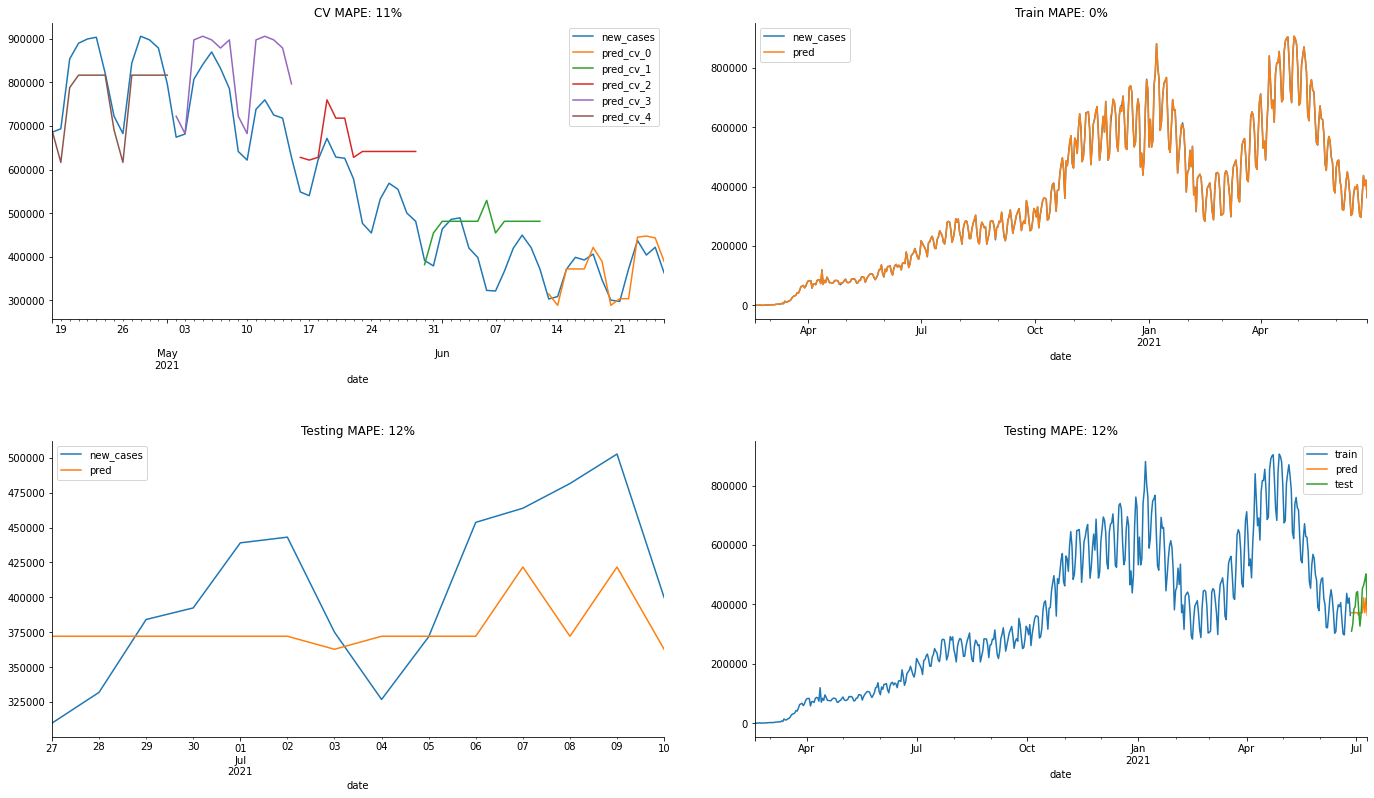

In [68]:
params = {'max_depth': [3, 5, 8, 10, 12, 15, 20], 'criterion': ['mae'], 
          'min_samples_split': [2, 4, 8, 10, 12, 15], 'min_samples_leaf': [1, 2, 3, 4, 5]}
regressor = DecisionTreeRegressor()

results = check_model(regressor, params, dataset, features=features, categorical_features=categorical_features)
results['best_params']

# Visualization

In [54]:
rt = DecisionTreeRegressor(
    criterion='mse', 
    max_depth=3, 
    min_samples_split=4, 
    min_samples_leaf=2, 
    random_state=42, 
)

In [55]:
rt.fit(dataset[features], dataset[target])

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

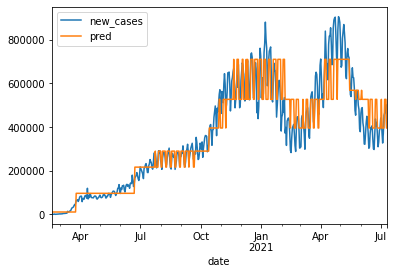

In [56]:
dataset['pred'] = rt.predict(dataset[features])
dataset[['date', target, 'pred']].plot(x='date', y=[target, 'pred'])

In [57]:
#https://github.com/parrt/dtreeviz
!pip install dtreeviz
from dtreeviz.trees import dtreeviz

     |████████████████████████████████| 61kB 2.4MB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3-cp37-none-any.whl size=66640 sha256=d54fbd5a2db29518e993c70e3a92dbaf10f2d29b806cdfa5415797a0fd1e0ccb
  Stored in directory: /root/.cache/pip/wheels/60/36/b1/188ee35c677e48463f6482d580f81c19f5f82ae5adbe293fd8
Successfully built dtreeviz


In [58]:
viz = dtreeviz(rt, dataset[features], dataset[target],
                target_name=target,
                feature_names=features)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


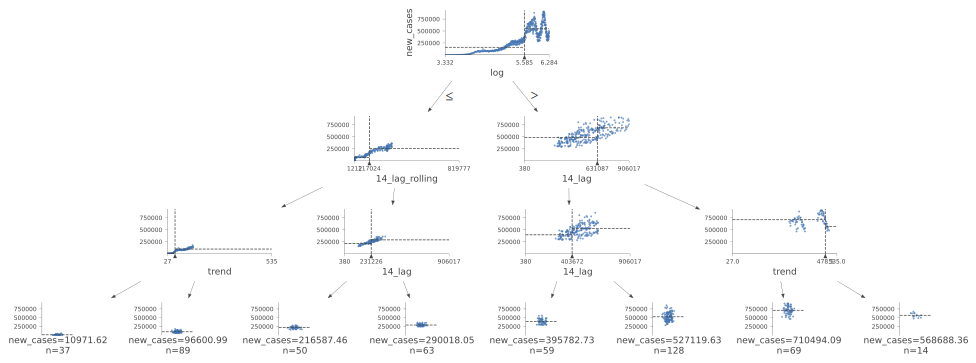

In [59]:
viz

## RandomForest

In [60]:
from sklearn.ensemble import RandomForestRegressor

Grid search
Fitting to train
Plot


{'regressor__criterion': 'mae',
 'regressor__max_depth': 8,
 'regressor__min_samples_leaf': 1,
 'regressor__min_samples_split': 3,
 'regressor__n_estimators': 100,
 'regressor__random_state': 42}

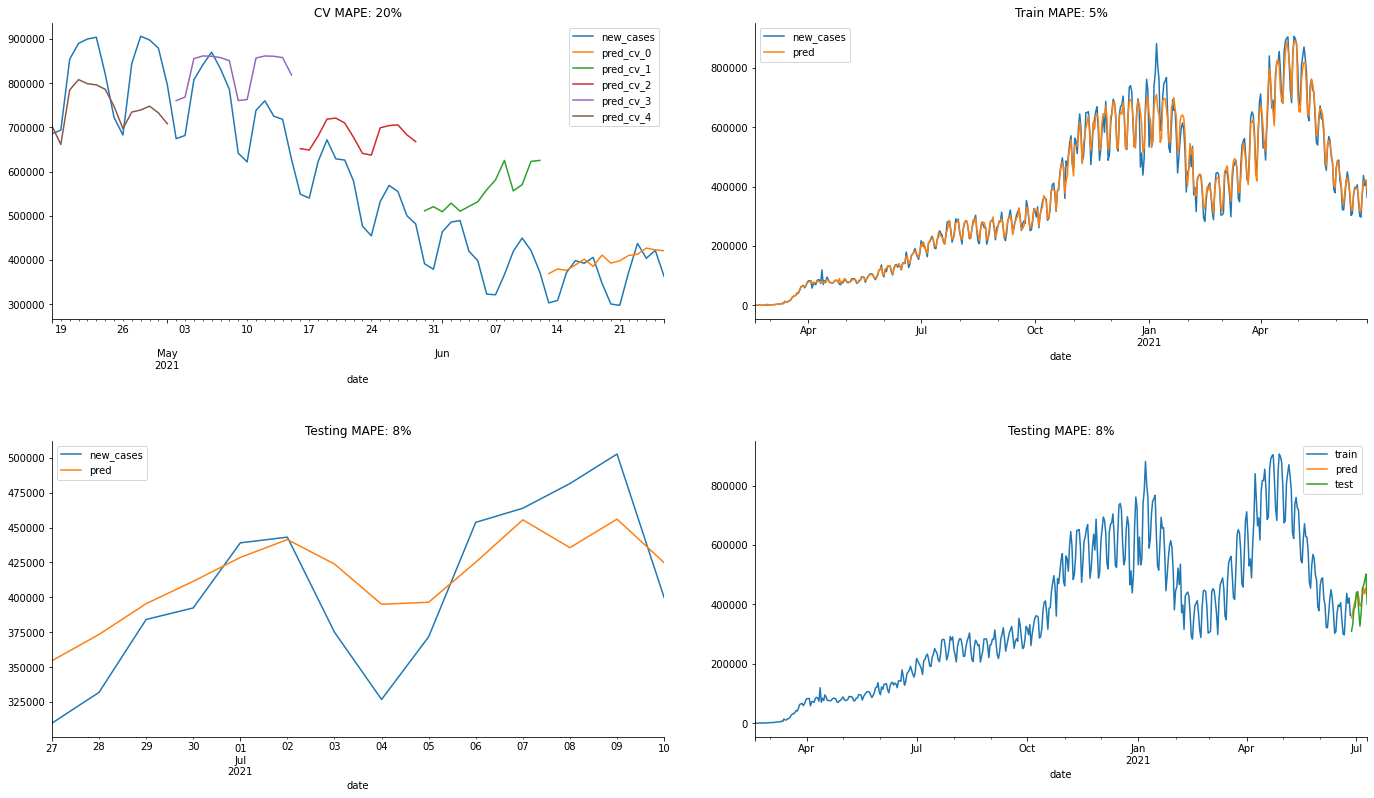

In [69]:
params = {'n_estimators': [100], 'criterion': ['mae'], 
          'max_depth': [8, 15], 'min_samples_split': [2, 3, 4], 
          'random_state': [42], 'min_samples_leaf': [1, 2, 3]}
regressor = RandomForestRegressor()

results = check_model(regressor, params, dataset, features=features, categorical_features=categorical_features)
results['best_params']

## XGBoost

In [62]:
#https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
from xgboost import XGBRegressor

Grid search
Fitting to train
Plot


{'regressor__max_depth': 20,
 'regressor__n_estimators': 100,
 'regressor__objective': 'reg:squarederror',
 'regressor__subsample': 1.0}

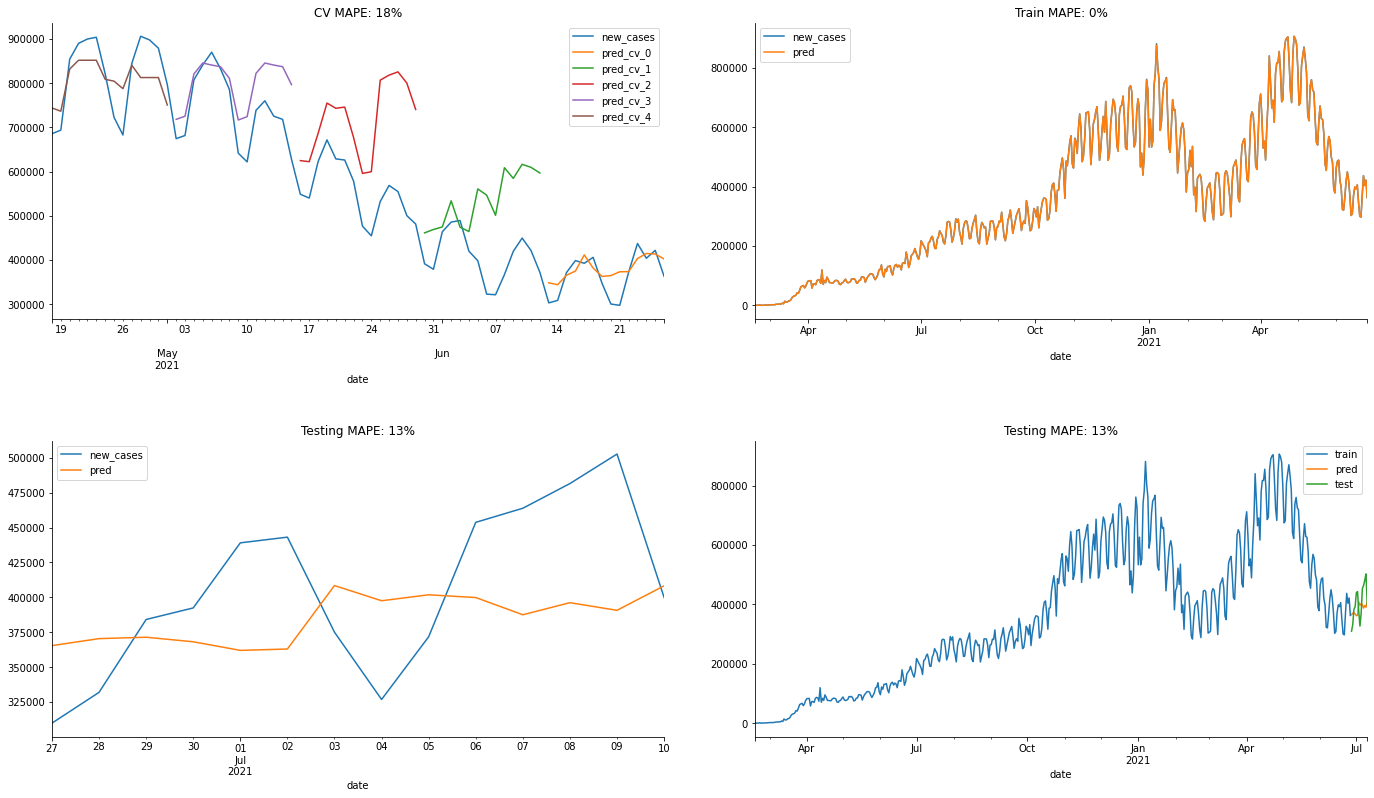

In [70]:
params = {'n_estimators': [100], 'max_depth': [8, 15, 20],'objective': ['reg:squarederror'], 'subsample': [1.0]}
regressor = XGBRegressor()

results = check_model(regressor, params, dataset, features=features, categorical_features=categorical_features)
results['best_params']

## Light GBM

In [64]:
#https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor
from lightgbm import LGBMRegressor

Grid search
Fitting to train
Plot


{'regressor__learning_rate': 0.2,
 'regressor__max_depth': 9,
 'regressor__n_estimators': 400,
 'regressor__num_leaves': 20,
 'regressor__objective': 'regression',
 'regressor__random_state': 42}

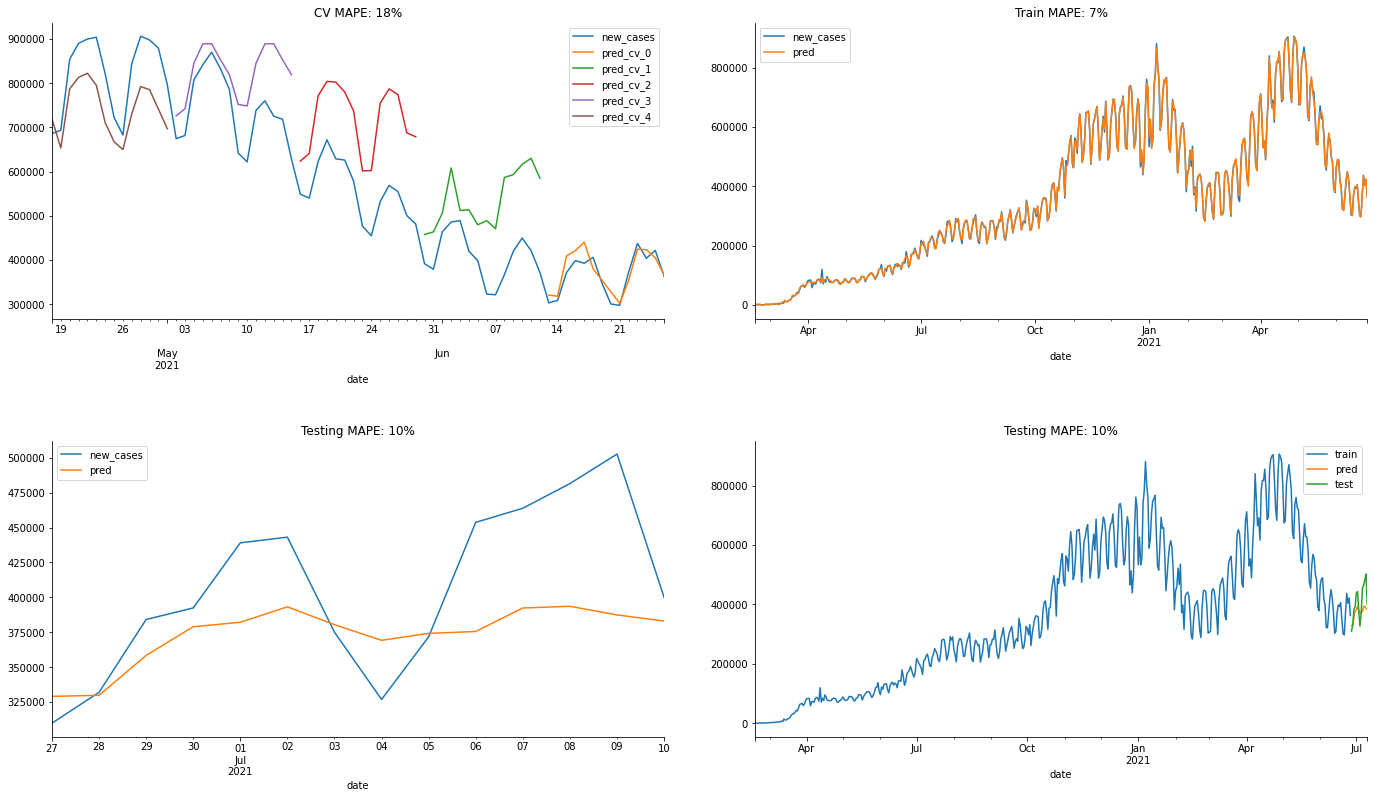

In [71]:
params = {'n_estimators': [300, 400], 
          'max_depth': [8, 9, 11, 13, 15],'objective': ['regression'], 
          'learning_rate': [0.05, 0.1, 0.2], 'num_leaves': [20, 31, 40],
          'random_state': [42]}
regressor = LGBMRegressor()

results = check_model(regressor, params, dataset, features=features, categorical_features=categorical_features)
results['best_params']

# Summary

In [ ]:
models = {
    LinearRegression(fit_intercept=False): {'fit_intercept': [False]},

    SVR(): {'C': [50000, 100000], 'kernel': ['rbf']},

    DecisionTreeRegressor(): {'max_depth': [8, 10, 12], 'criterion': ['mae'], 
          'min_samples_split': [4, 8, 10], 'min_samples_leaf': [1, 2]},

    RandomForestRegressor(): {'n_estimators': [100], 'criterion': ['mae'], 
          'max_depth': [8, 15], 'min_samples_split': [2, 3, 4], 
          'random_state': [42], 'min_samples_leaf': [1, 2, 3]},

    XGBRegressor(): {'n_estimators': [100], 'max_depth': [8, 15, 20],'objective': ['reg:squarederror'], 'subsample': [1.0]},

    LGBMRegressor(): {'n_estimators': [300], 
          'max_depth': [13, 15],'objective': ['regression'], 
          'learning_rate': [0.05, 0.1, 0.2], 'num_leaves': [20, 31],
          'random_state': [42]},
}

results_array = []
for regressor, params in models.items():
  results_array.append(check_model(regressor, params, dataset, plotting=False, features=features, categorical_features=categorical_features))

Grid search
Fitting to train
Grid search
Fitting to train
Grid search
Fitting to train
Grid search


In [ ]:
pd.DataFrame(results_array).sort_values('mae_cv')